In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/MyDrive/ECE1512_ProjectA/Project_A_Supp')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [4]:
test_dir = 'hmt_dataset/HMT_test' 
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 496 images belonging to 8 classes.


Overrided

# Task3-1

In [5]:
model=load_model('models/HMT.h5')

In [6]:
STEP_SIZE_TEST=test_generator.n
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


496/496 [==============================] - 142s 271ms/step


In [7]:
y_pred = pred.argmax(axis=-1)
y_actual = test_generator.labels

In [8]:
## Overall Accuracy
metrics.accuracy_score(y_pred,y_actual)

0.8346774193548387

In [9]:
## Class-wise Classification Accuracy for all class
acc = []
labels = [k for k,_ in test_generator.class_indices.items()]
for i in range(8):
  class_ind = np.where(y_actual==i)  
  predicted = y_pred[class_ind[0]]
  print('class: {0}: {1}, accuracy: {2}'.format(i,labels[i],metrics.accuracy_score(predicted,y_actual[class_ind[0]])))

class: 0: 01_TUMOR, accuracy: 0.8548387096774194
class: 1: 02_STROMA, accuracy: 0.7580645161290323
class: 2: 03_COMPLEX, accuracy: 0.7741935483870968
class: 3: 04_LYMPHO, accuracy: 0.8548387096774194
class: 4: 05_DEBRIS, accuracy: 0.6612903225806451
class: 5: 06_MUCOSA, accuracy: 0.8225806451612904
class: 6: 07_ADIPOSE, accuracy: 0.9516129032258065
class: 7: 08_EMPTY, accuracy: 1.0


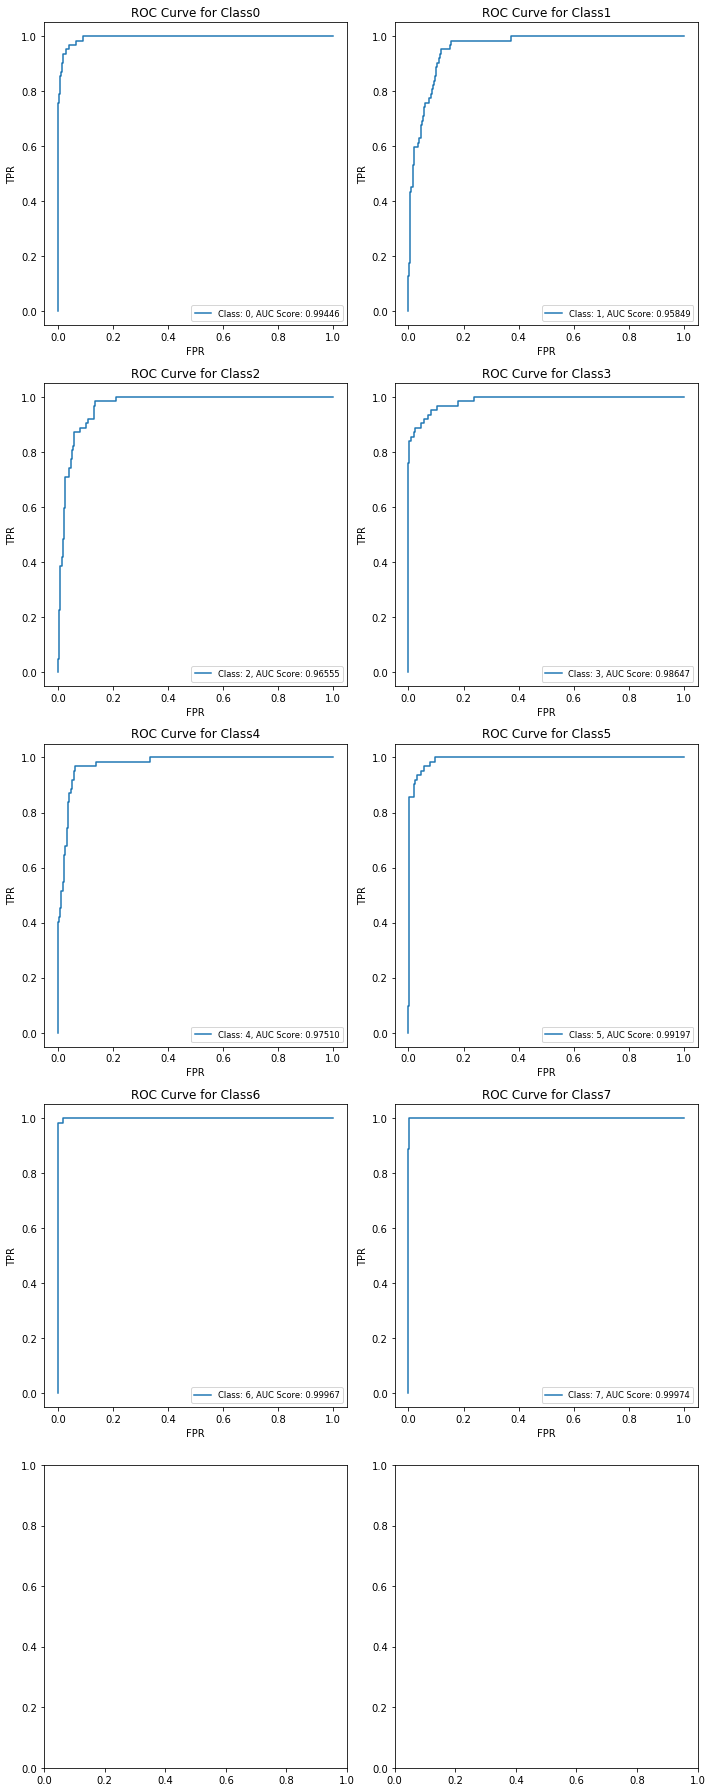

In [10]:
#ROC and AUC Curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
y_test = y_actual
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred_transformed = lb.transform(y_pred)
y_score = pred

fig, ax = plt.subplots(5,2,figsize=(10,25))
i = 0
for row in range(4):
  for col in range(2):
    fpr, tpr, thresholds = metrics.roc_curve(y_test[:,i].astype(int), y_score[:,i])

    ax[row,col].plot(fpr, tpr,label = "Class: {0}, AUC Score: {1:.5f}".format(i,metrics.auc(fpr,tpr)))    
    ax[row,col].legend(loc='best', fontsize = 'small')
    ax[row,col].set_title('ROC Curve for Class{}'.format(i))
    ax[row,col].set(xlabel='FPR', ylabel='TPR')
    i+=1

fig.tight_layout()

Text(0.5, 1.0, 'Confusion Matrix')

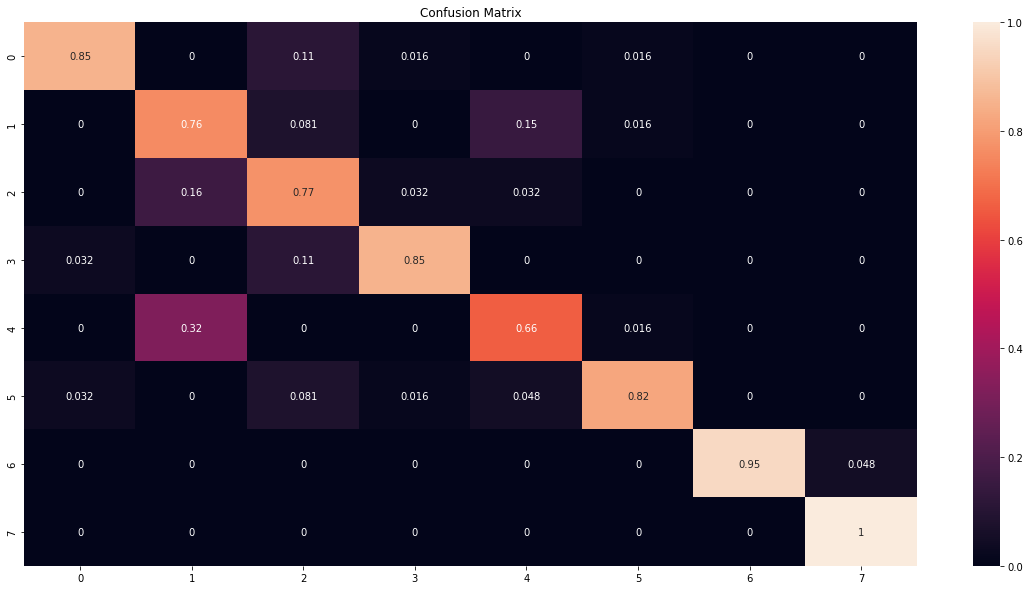

In [ ]:
## Confusion Matrix
import seaborn as sn

confusion_matrix = metrics.confusion_matrix(y_actual, y_pred,normalize='true')
df_confusion_matrix = pd.DataFrame(confusion_matrix, index = [i for i in range(0,8,1)],
                  columns = [i for i in range(0,8,1)])
plt.figure(figsize=(20,10))
sn.heatmap(df_confusion_matrix, annot=True)
plt.title('Confusion Matrix')

In [ ]:
## Presion Recall F1 Score
print(metrics.classification_report(y_pred,y_actual))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        57
           1       0.76      0.61      0.68        77
           2       0.77      0.67      0.72        72
           3       0.85      0.93      0.89        57
           4       0.66      0.75      0.70        55
           5       0.82      0.94      0.88        54
           6       0.95      1.00      0.98        59
           7       1.00      0.95      0.98        65

    accuracy                           0.83       496
   macro avg       0.83      0.85      0.84       496
weighted avg       0.83      0.83      0.83       496



# Task 3-2

Load the explaier library

In [ ]:
from xai_utils import *

Load a batch of images

In [ ]:
test_generator.reset()

In [ ]:
image_batch,label_batch=test_generator.next()

Classes:

In [ ]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [ ]:
index=8

In [ ]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


Generate explanation map

Set the layer(s)

In [ ]:
layers=[['conv2d_3']]

### Grad-CAM (Gradient-based Class Activation Mapping)

In [ ]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 443 ms, sys: 39.9 ms, total: 483 ms
Wall time: 939 ms


In [ ]:
test_generator[0][1][31]

array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Integrated Gradients

In [ ]:
### Adapted From https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
import tensorflow as tf

def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

  
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
      
  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
baseline = tf.zeros(shape=(224,224,3))

In [ ]:
#@title
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)


  return attribution_mask

### Lime

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 4.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=089c2ba772947f710c0fe96b0b9792b8e1a232e80561ce447c854a433caede83
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from scipy.ndimage.interpolation import zoom

def Lime(image, target_class_idx):

  score_list = []

  explainer = LimeImageExplainer(random_state=0)

  classifier_fn = lambda x: model.predict(x)

  explanation = explainer.explain_instance(
      image.astype('double'), classifier_fn=classifier_fn, 
      labels=target_class_idx, num_samples=1000, num_features=224*224)

  temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=15, hide_rest=True)

  exp = mark_boundaries(temp, mask)

  local_exp = explanation.local_exp[target_class_idx]


  local_exp = sorted(local_exp,key=lambda x: x[0])


  local_exp = np.array(local_exp)

  for feat, score in local_exp:
    score_list.append(score)

  H,W= image.shape[0:2]

  score_list = np.resize(score_list, (H, W))

  score_list = np.maximum(score_list, 0)

  score_list = zoom(score_list,(H/score_list.shape[0],W/score_list.shape[1]))

  score_list = np.maximum(score_list, 0)

  score_list = score_list/score_list.max()

  return exp, temp, mask, score_list

### Summarize Results

0
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.8558131


  0%|          | 0/1000 [00:00<?, ?it/s]

1
True label: Stroma
Predicted_label: Stroma
Confidence score for the correct label: 0.61255985


  0%|          | 0/1000 [00:00<?, ?it/s]

2
True label: Complex
Predicted_label: Complex
Confidence score for the correct label: 0.78166574


  0%|          | 0/1000 [00:00<?, ?it/s]

3
True label: Lympho
Predicted_label: Complex
Confidence score for the correct label: 0.76736397


  0%|          | 0/1000 [00:00<?, ?it/s]

4
True label: Debris
Predicted_label: Stroma
Confidence score for the correct label: 0.6257713


  0%|          | 0/1000 [00:00<?, ?it/s]

5
True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.92712176


  0%|          | 0/1000 [00:00<?, ?it/s]

6
True label: Adiopse
Predicted_label: Adiopse
Confidence score for the correct label: 0.9822489


  0%|          | 0/1000 [00:00<?, ?it/s]

7
True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.9031276


  0%|          | 0/1000 [00:00<?, ?it/s]

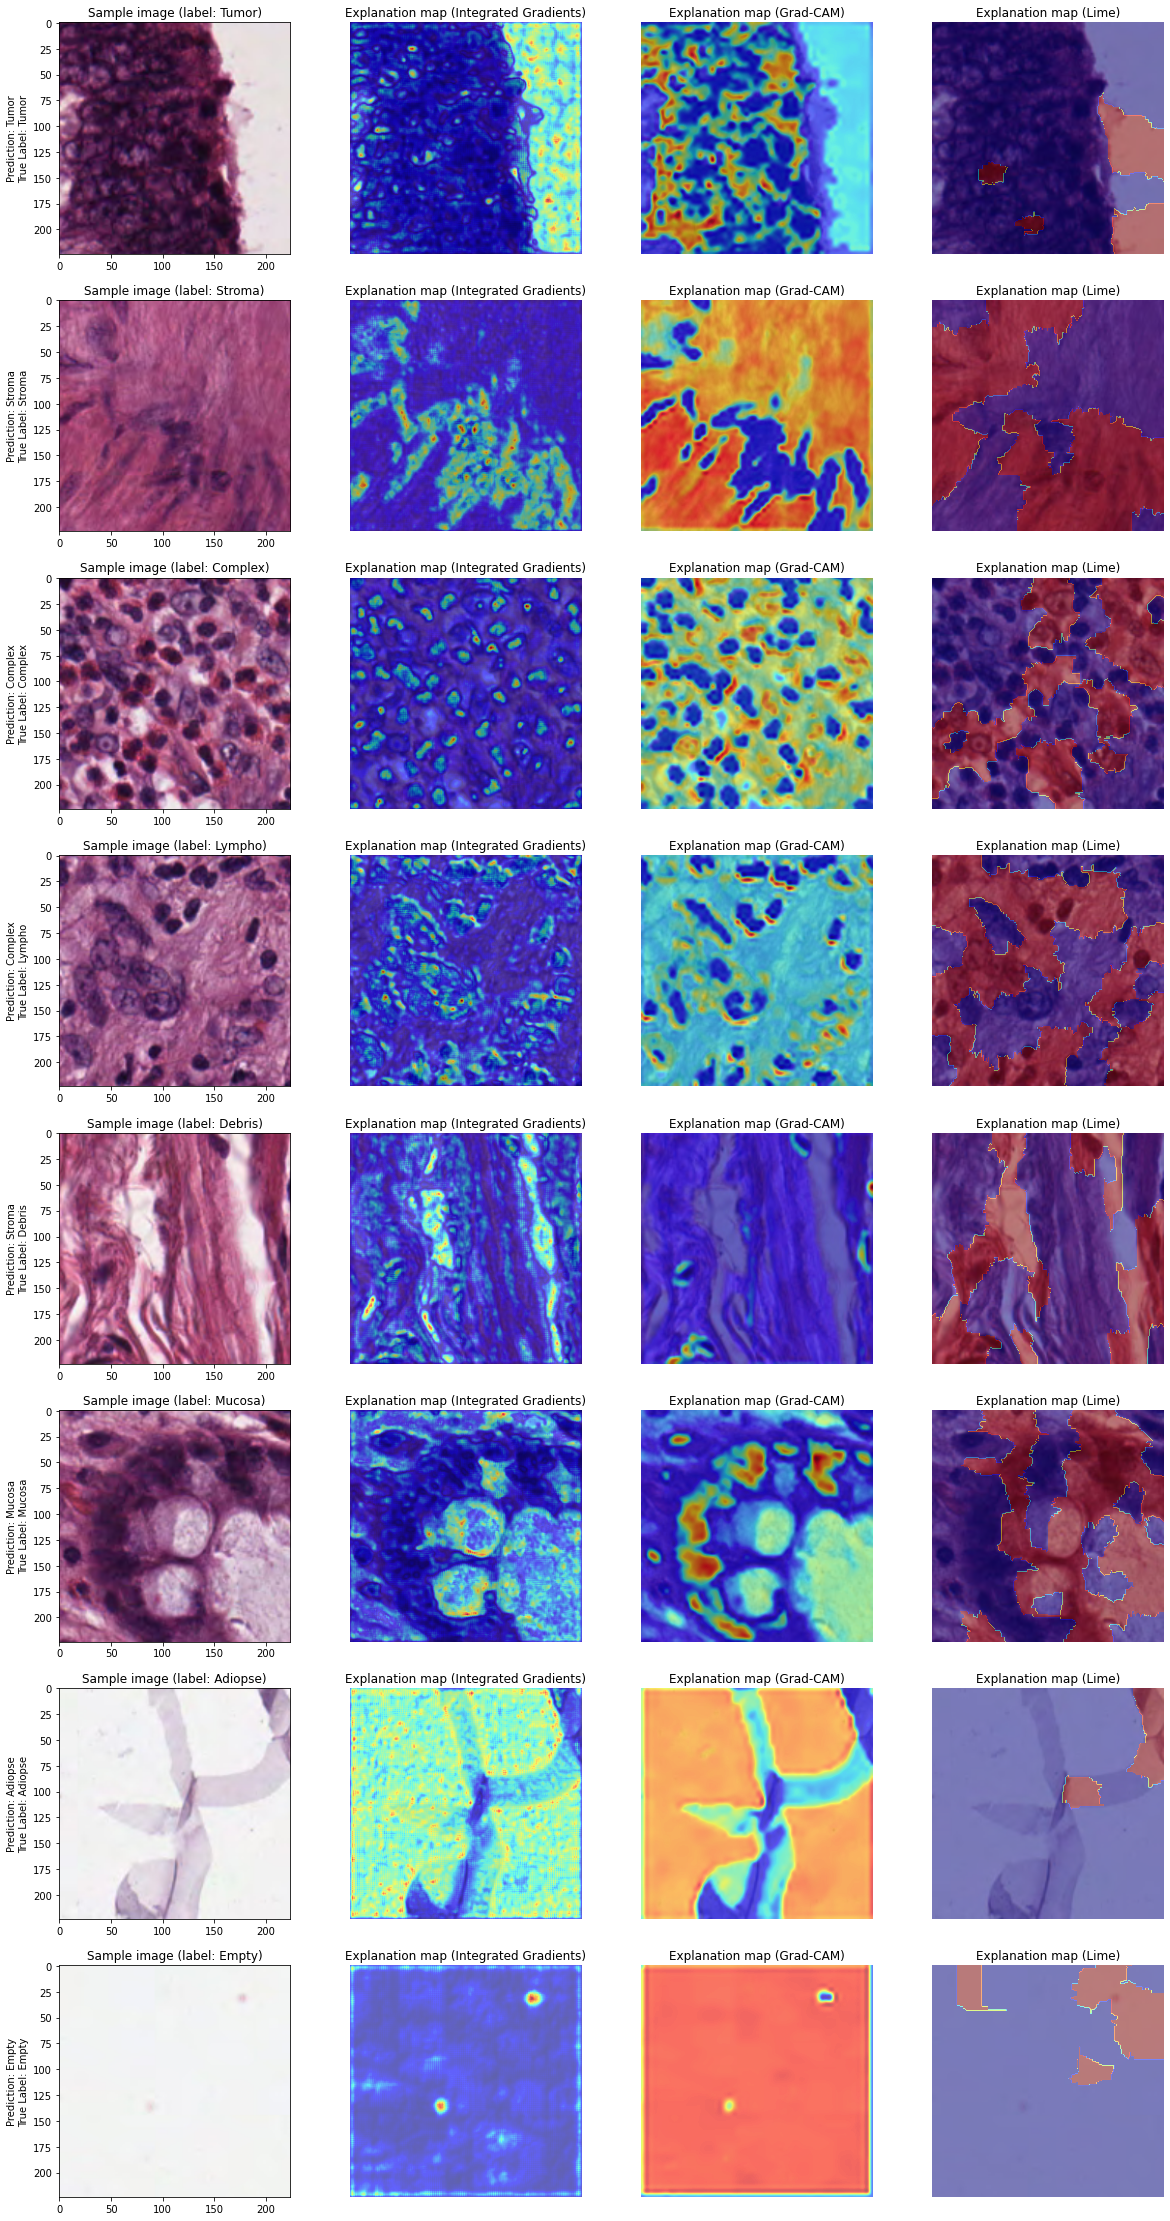

In [ ]:
plt.figure(figsize=(20,40))

for i in range(8):
  print(i)
  index = np.where(y_actual==i)[0][0]
  batch_index = index//32 #batch size=32
  remainder_index = index%32
  label = classes[np.argmax(y_test[index])]
  prediction = classes[y_pred[index]]
  print('True label: '+ label)
  print('Predicted_label: '+prediction)
  print('Confidence score for the correct label: '+str(np.max(pred[index])))

  # test_generator[batch_index][0=x_test,1=label_in_one_hot][remainder_index]
  explanation_map_GradCAM = grad_cam(model, np.expand_dims(test_generator[batch_index][0][remainder_index], axis=0), 'max_pooling2d_1')
  explanation_map_GradCAM -= explanation_map_GradCAM.min()
  explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

  image = test_generator[batch_index][0][remainder_index]
  explanation_map_IG = plot_img_attributions(image=image,
                          baseline=baseline,
                          target_class_idx=y_pred[index],
                          m_steps=240)
  
  explanation_map_Lime,temp, mask, score_list = Lime(image, target_class_idx=y_pred[index])

  plt.subplot(8,4,4*i+1)
  plt.imshow(test_generator[batch_index][0][remainder_index])
  plt.title('Sample image (label: %s)' %(label))
  plt.ylabel('Prediction: ' +prediction + '\nTrue Label: '+label)

  plt.subplot(8,4,4*i+2)
  plt.imshow(explanation_map_IG, cmap='jet')
  plt.imshow(test_generator[batch_index][0][remainder_index], alpha=0.4)
  plt.axis('off')
  plt.title('Explanation map (Integrated Gradients)')


  plt.subplot(8,4,4*i+3)
  plt.imshow(explanation_map_GradCAM, cmap='jet')
  plt.imshow(test_generator[batch_index][0][remainder_index],alpha = 0.4)
  plt.axis('off')
  plt.title('Explanation map (Grad-CAM)')

  plt.subplot(8,4,4*i+4)
  plt.imshow(test_generator[batch_index][0][remainder_index])
  plt.imshow(mask, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Explanation map (Lime)')

plt.savefig('Explanaition Map Histophology.svg')
plt.show()

0
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.8558131


  0%|          | 0/1000 [00:00<?, ?it/s]

1
True label: Stroma
Predicted_label: Stroma
Confidence score for the correct label: 0.61255985


  0%|          | 0/1000 [00:00<?, ?it/s]

2
True label: Complex
Predicted_label: Complex
Confidence score for the correct label: 0.78166574


  0%|          | 0/1000 [00:00<?, ?it/s]

3
True label: Lympho
Predicted_label: Complex
Confidence score for the correct label: 0.76736397


  0%|          | 0/1000 [00:00<?, ?it/s]

4
True label: Debris
Predicted_label: Stroma
Confidence score for the correct label: 0.6257713


  0%|          | 0/1000 [00:00<?, ?it/s]

5
True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.92712176


  0%|          | 0/1000 [00:00<?, ?it/s]

6
True label: Adiopse
Predicted_label: Adiopse
Confidence score for the correct label: 0.9822489


  0%|          | 0/1000 [00:00<?, ?it/s]

7
True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.9031276


  0%|          | 0/1000 [00:00<?, ?it/s]

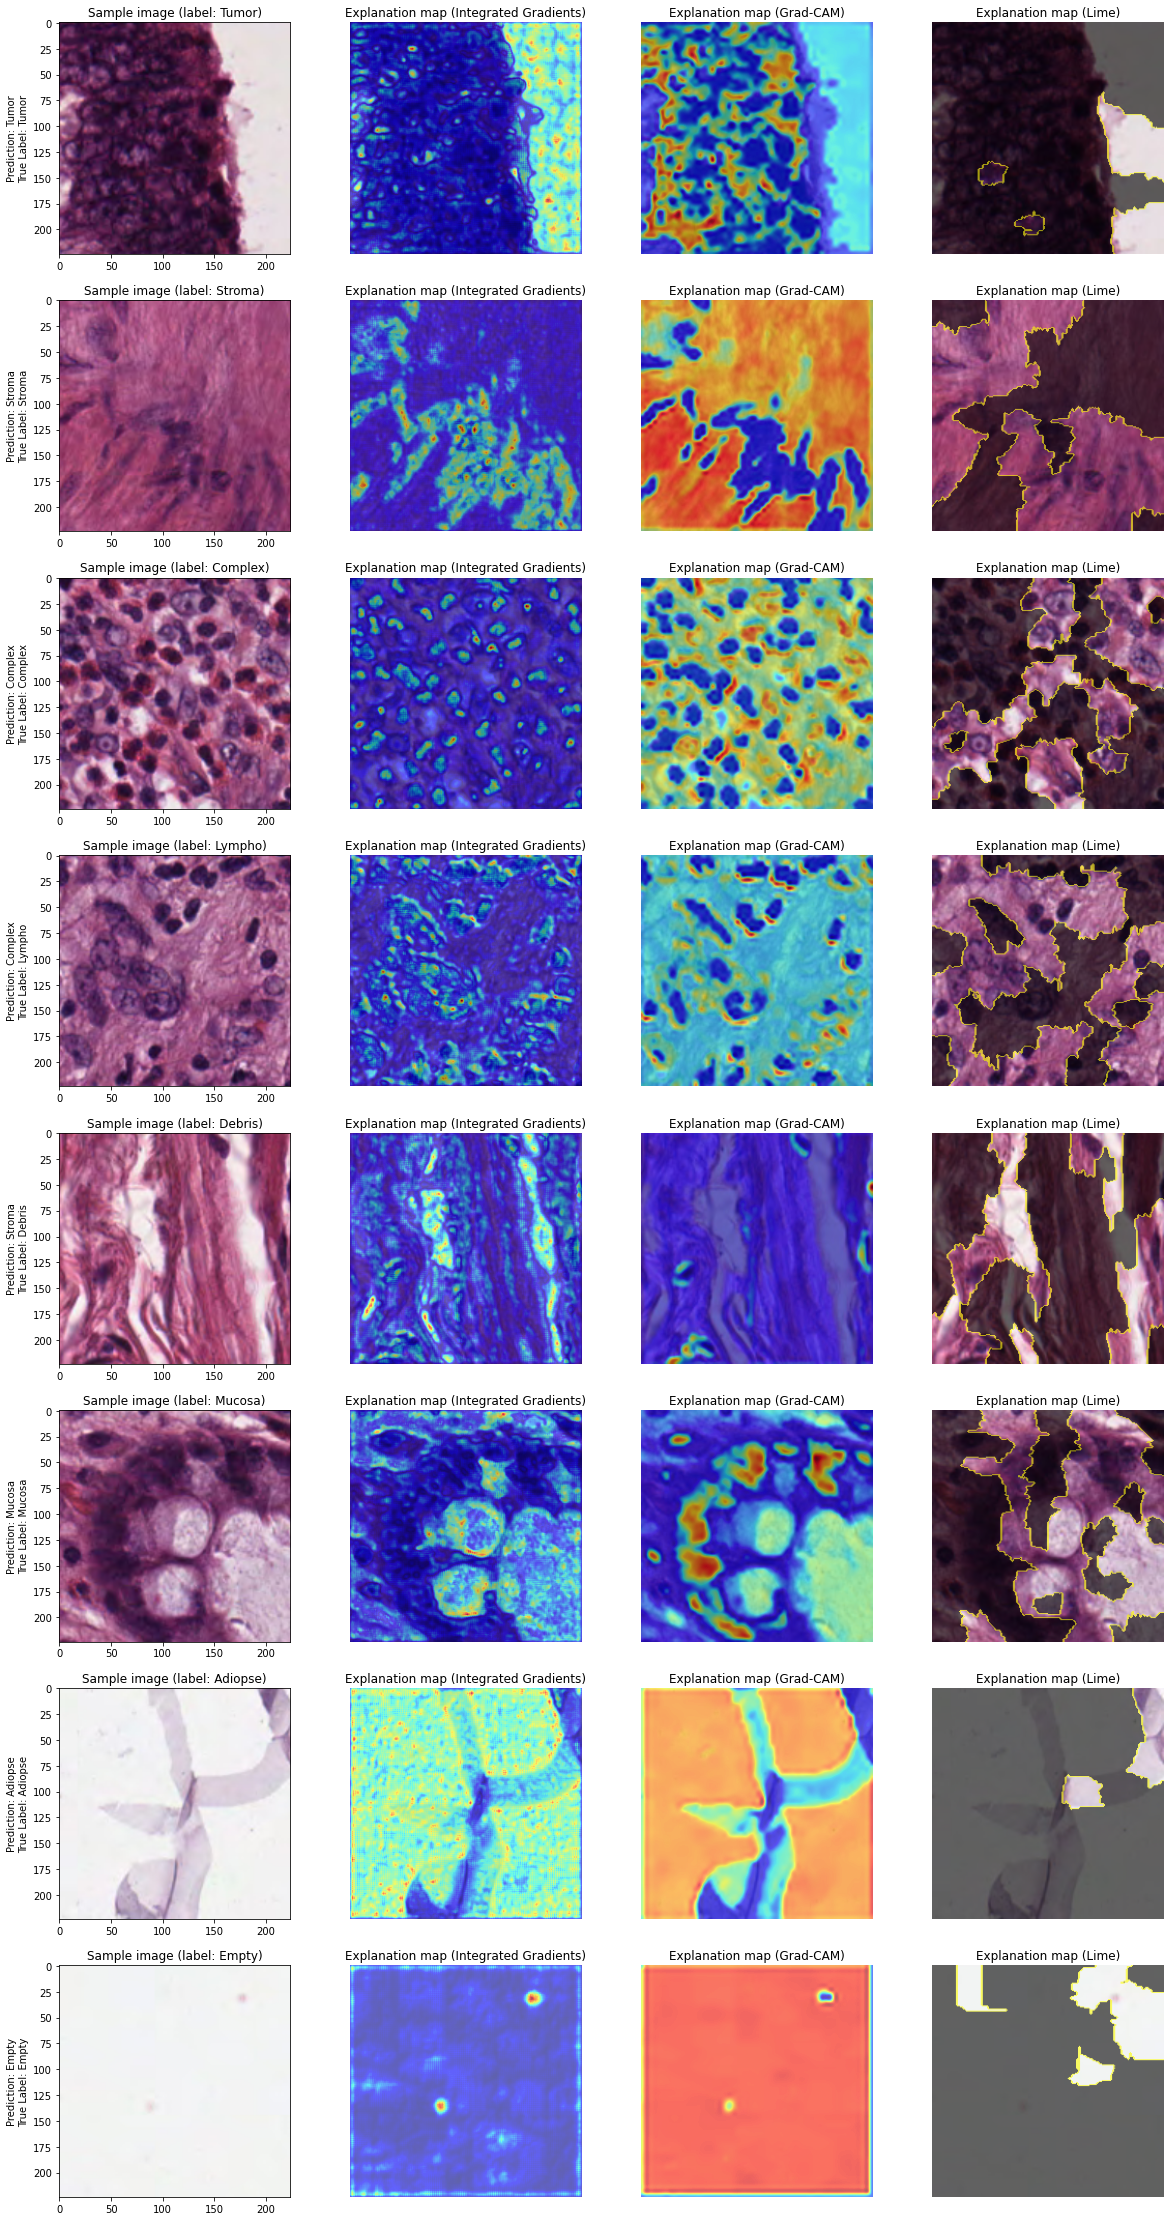

In [ ]:
plt.figure(figsize=(20,40))

for i in range(8):
  print(i)
  index = np.where(y_actual==i)[0][0]
  batch_index = index//32 #batch size=32
  remainder_index = index%32
  label = classes[np.argmax(y_test[index])]
  prediction = classes[y_pred[index]]
  print('True label: '+ label)
  print('Predicted_label: '+prediction)
  print('Confidence score for the correct label: '+str(np.max(pred[index])))

  # test_generator[batch_index][0=x_test,1=label_in_one_hot][remainder_index]
  explanation_map_GradCAM = grad_cam(model, np.expand_dims(test_generator[batch_index][0][remainder_index], axis=0), 'max_pooling2d_1')
  explanation_map_GradCAM -= explanation_map_GradCAM.min()
  explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

  image = test_generator[batch_index][0][remainder_index]
  explanation_map_IG = plot_img_attributions(image=image,
                          baseline=baseline,
                          target_class_idx=y_pred[index],
                          m_steps=240)
  
  explanation_map_Lime,_,_,_ = Lime(image, target_class_idx=y_pred[index])

  plt.subplot(8,4,4*i+1)
  plt.imshow(test_generator[batch_index][0][remainder_index])
  plt.title('Sample image (label: %s)' %(label))
  plt.ylabel('Prediction: ' +prediction + '\nTrue Label: '+label)

  plt.subplot(8,4,4*i+2)
  plt.imshow(explanation_map_IG, cmap='jet')
  plt.imshow(test_generator[batch_index][0][remainder_index], alpha=0.4)
  plt.axis('off')
  plt.title('Explanation map (Integrated Gradients)')


  plt.subplot(8,4,4*i+3)
  plt.imshow(explanation_map_GradCAM, cmap='jet')
  plt.imshow(test_generator[batch_index][0][remainder_index],alpha = 0.4)
  plt.axis('off')
  plt.title('Explanation map (Grad-CAM)')

  plt.subplot(8,4,4*i+4)
  plt.imshow(explanation_map_Lime)
  plt.imshow(test_generator[batch_index][0][remainder_index],alpha = 0.4)
  plt.axis('off')
  plt.title('Explanation map (Lime)')

plt.savefig('Explanaition Map Histophology.svg')
plt.show()

## Quantitative evaluation of the explanation algorithm

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        drop, increase, _, _= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GradCAM, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate += drop
        increase_rate += increase
drop_rate /= (15*32)
increase_rate /= (15*32)

print('Method 1: Grad-CAM')
print('Drop rate: %.3f' %(drop_rate))
print('Increase rate: %.3f' %(increase_rate))

Method 1: Grad-CAM
Drop rate: 0.489
Increase rate: 0.296


In [ ]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        print(index)
        prediction=model(image_batch)
        image = tf.convert_to_tensor(image_batch[index])
        explanation_map_IG = plot_img_attributions(image=image,
                          baseline=baseline,
                          target_class_idx=np.argmax(prediction[index]),
                          m_steps=240)
        explanation_map_IG = explanation_map_IG.numpy()
        drop, increase, _, _= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_IG, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate += drop
        increase_rate += increase
        print(drop_rate / (15*32))
drop_rate /= (15*32)
increase_rate /= (15*32)

print('Method 2: Integrated Gradients')
print('Drop rate: %.3f' %(drop_rate))
print('Increase rate: %.3f' %(increase_rate))

Method 2: Integrated Gradients
Drop rate: 0.375
Increase rate: 0.310


In [ ]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for n in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        try:
          _,_,_,explanation_map_Lime = Lime(image_batch[index], np.argmax(prediction[index]))
        except KeyError:
          pass
        drop, increase, _, _= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Lime, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate += drop
        increase_rate += increase
drop_rate /= (15*32)
increase_rate /= (15*32)

print('Method 3: Lime')
print('Drop rate: %.3f' %(drop_rate))
print('Increase rate: %.3f' %(increase_rate))

Method 3: Lime
Drop rate: 0.402
Increase rate: 0.275
